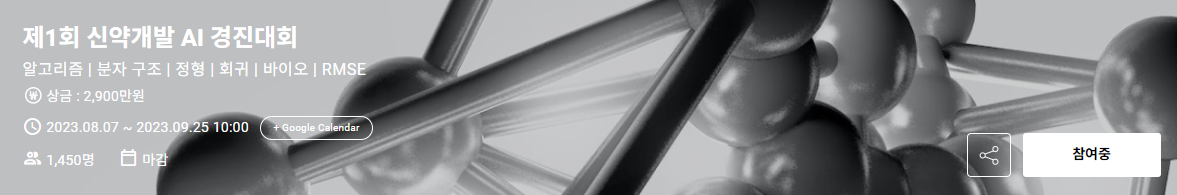

## Import

In [7]:
# !pip install catboost
# !pip install pycaret[full]
# !pip install sklearn
# !pip install --upgrade scipy
# !pip install rdkit
# !pip install molfeat
# !pip install datamol
# !pip install xgboost
# !pip install torch
# !pip install os
# !pip install random
!pip install pandas


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import random
import os

import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [9]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/medicine/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/medicine/test.csv')
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [10]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
seed=1111
seed_everything(seed) # Seed 고정


# EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   smiles                      3498 non-null   object 
 2   mlm                         3498 non-null   float64
 3   hlm                         3498 non-null   float64
 4   alogp                       3496 non-null   float64
 5   molecular_weight            3498 non-null   float64
 6   num_h_acceptors             3498 non-null   int64  
 7   num_h_donors                3498 non-null   int64  
 8   num_rotatablebonds          3498 non-null   int64  
 9   logd                        3498 non-null   float64
 10  molecular_polarsurfacearea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          483 non-null    object 
 1   smiles                      483 non-null    object 
 2   alogp                       482 non-null    float64
 3   molecular_weight            483 non-null    float64
 4   num_h_acceptors             483 non-null    int64  
 5   num_h_donors                483 non-null    int64  
 6   num_rotatablebonds          483 non-null    int64  
 7   logd                        483 non-null    float64
 8   molecular_polarsurfacearea  483 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 34.1+ KB


In [12]:
train.head()

,id,smiles,mlm,hlm,alogp,molecular_weight,num_h_acceptors,num_h_donors,num_rotatablebonds,logd,molecular_polarsurfacearea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<img src="https://blog.kakaocdn.net/dn/c2obPt/btrvNGYLgq0/k2YVsiYkVCoXKrdLoEeAX0/img.png" srcset="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&amp;fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fc2obPt%2FbtrvNGYLgq0%2Fk2YVsiYkVCoXKrdLoEeAX0%2Fimg.png" onerror="this.onerror=null; this.src='//t1.daumcdn.net/tistory_admin/static/images/no-image-v1.png'; this.srcset='//t1.daumcdn.net/tistory_admin/static/images/no-image-v1.png';" width="680" height="245" data-origin-width="864" data-origin-height="312">

In [ ]:
train_eda = train.copy()
# 단위 질량당 ~
train_eda['polar_area_per_weight'] = train['molecular_polarsurfacearea'] / train['molecular_weight']
train_eda['acceptors_per_weight'] = train['num_h_acceptors'] / train['molecular_weight']
train_eda['donors_per_weight'] = train['num_h_donors'] / train['molecular_weight']
train_eda['rotat_weight'] = train['num_rotatablebonds'] / train['molecular_weight']
train_eda['func_per_weight'] =(train_eda['donors_per_weight']+train_eda['acceptors_per_weight']) / train['molecular_weight']
# 단위 면적당 ~
train_eda['donors_per_surf'] = train_eda['donors_per_weight'] / train['molecular_polarsurfacearea']
train_eda['acceptors_per_surf'] = train_eda['acceptors_per_weight'] / train['molecular_polarsurfacearea']
train_eda['func_per_surf'] = (train_eda['donors_per_weight']+train_eda['acceptors_per_weight']) / train['molecular_polarsurfacearea']
test_eda = test.copy()
test_eda['polar_area_per_weight'] = test['molecular_polarsurfacearea'] / test['molecular_weight']
test_eda['acceptors_per_weight'] = test['num_h_acceptors'] / test['molecular_weight']
test_eda['donors_per_weight'] = test['num_h_donors'] / test['molecular_weight']
test_eda['func_per_weight'] =(test_eda['donors_per_weight']+test_eda['acceptors_per_weight']) / test['molecular_weight']
test_eda['rotat_weight'] = test['num_rotatablebonds'] / test['molecular_weight']
test_eda['donors_per_surf'] = test_eda['donors_per_weight'] / test['molecular_polarsurfacearea']
test_eda['acceptors_per_surf'] = test_eda['acceptors_per_weight'] / test['molecular_polarsurfacearea']
test_eda['func_per_surf'] = (test_eda['donors_per_weight']+test_eda['acceptors_per_weight']) / test['molecular_polarsurfacearea']

## 분포도 확인

### 히스토그램


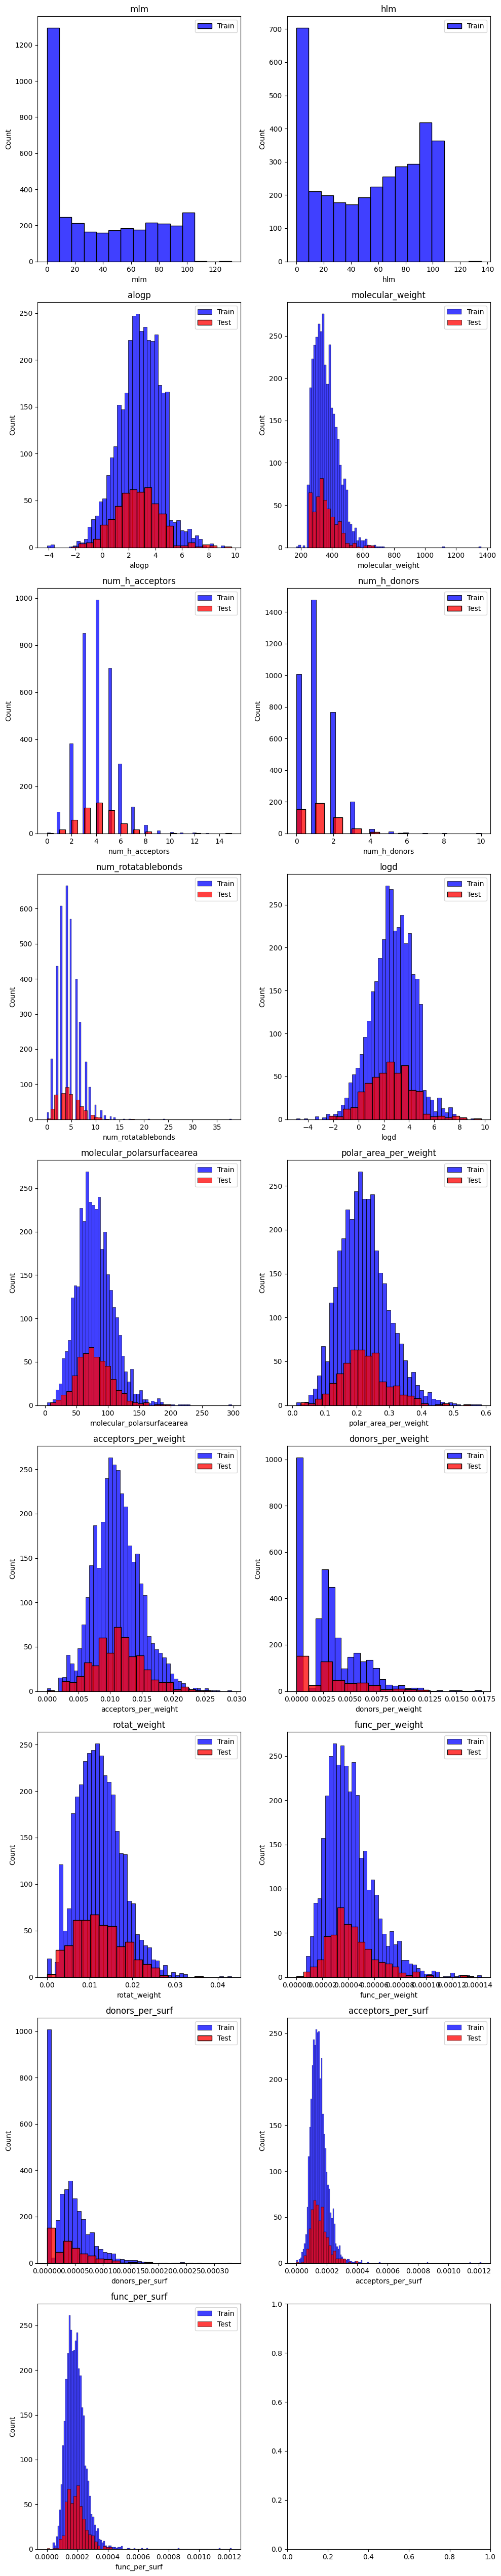

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
traincp = train_eda.drop(['id', 'smiles'], axis=1)
testcp = test_eda.drop(['id', 'smiles'], axis=1)

fig, axs = plt.subplots(len(traincp.columns)//2 + len(traincp.columns)%2, 2, figsize=(10, len(traincp.columns)*3))

for i, col in enumerate(traincp.columns):
    row = i // 2
    col_num = i % 2

    if col in testcp.columns:
        sns.histplot(traincp[col].dropna(), color='b', label='Train', ax=axs[row][col_num]) # NaN 제거 후 히스토그램 생성 (Train)
        sns.histplot(testcp[col].dropna(), color='r', label='Test', ax=axs[row][col_num]) # NaN 제거 후 히스토그램 생성 (Test)
    else :
        sns.histplot(traincp[col].dropna(), color='b', label='Train', ax=axs[row][col_num]) # NaN 제거 후 히스토그램 생성 (Train)

    axs[row][col_num].set_title(col)
    axs[row][col_num].legend()

plt.tight_layout()
plt.show()


## 박스플롯 및 산점도


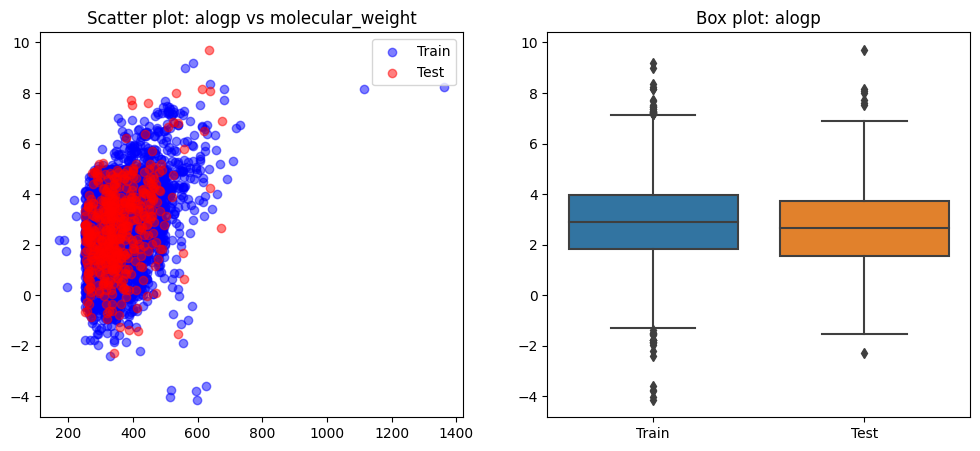

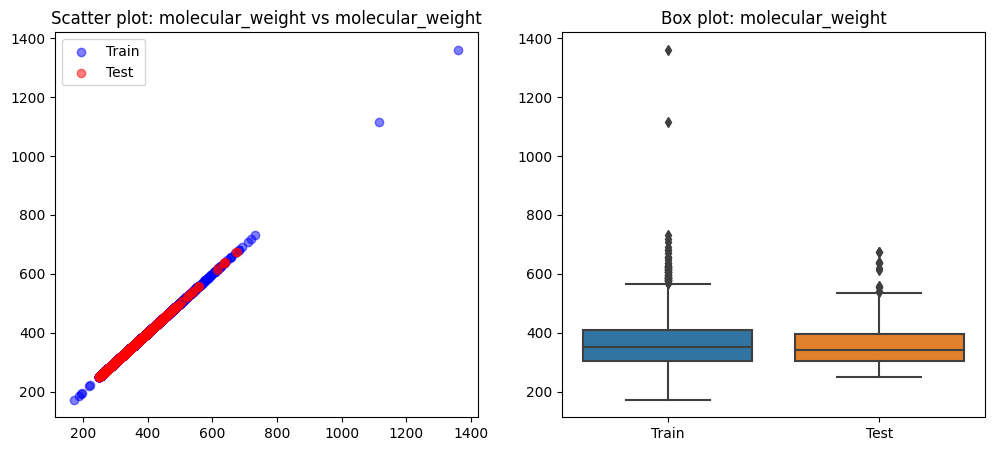

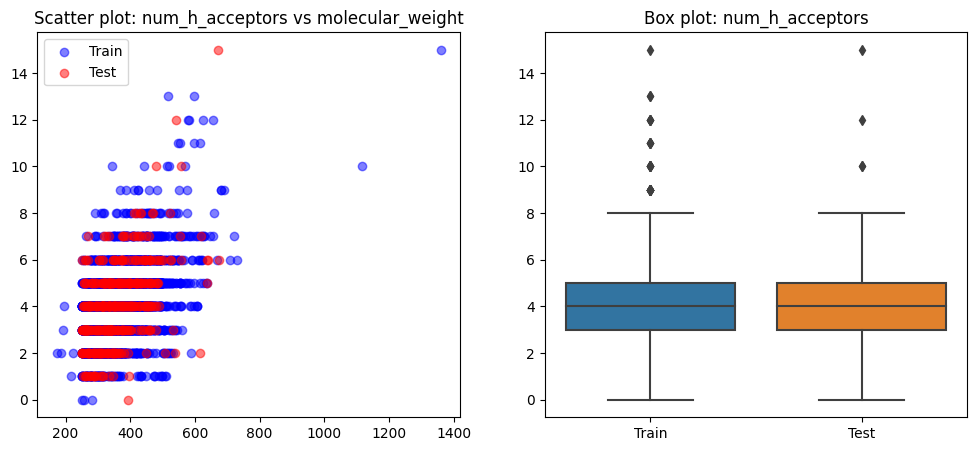

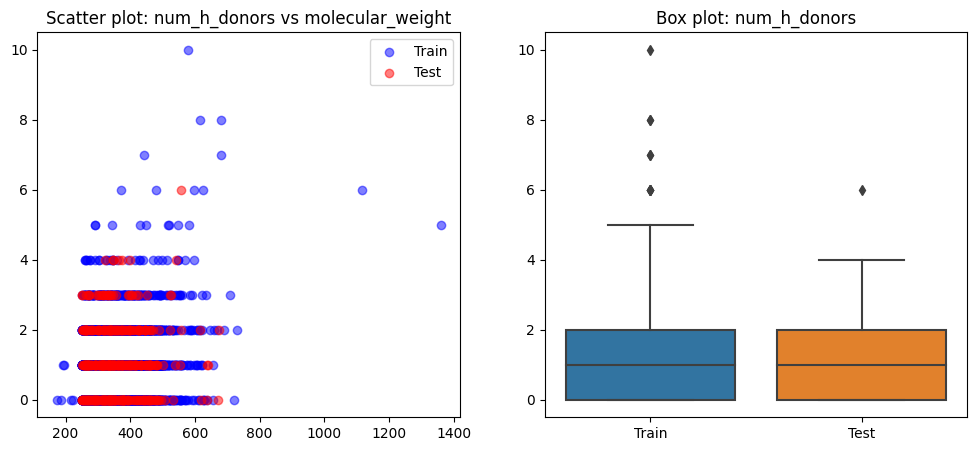

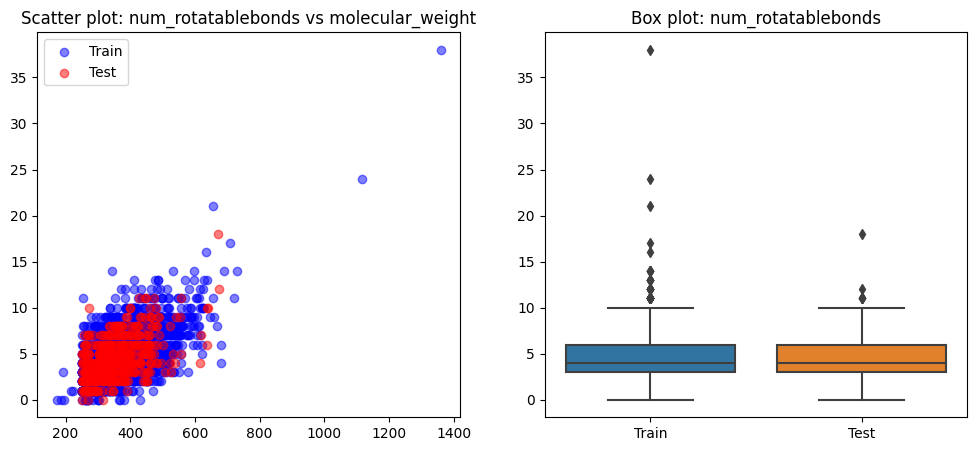

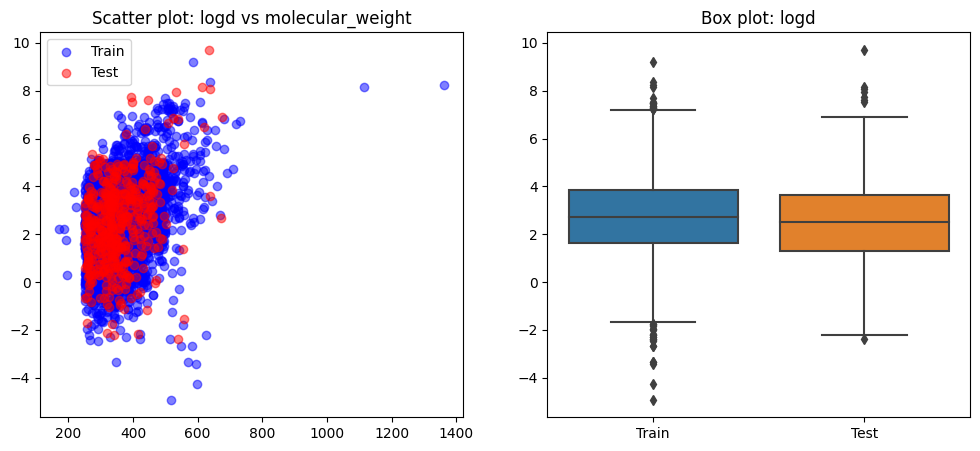

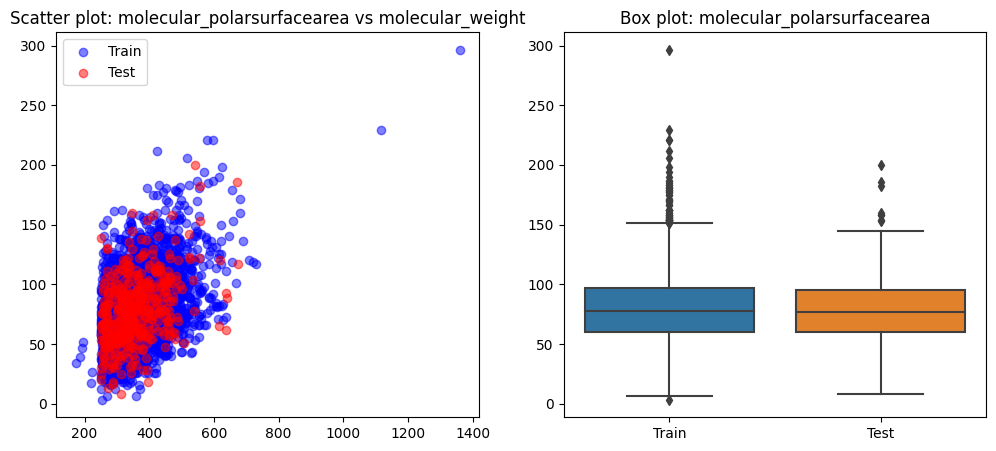

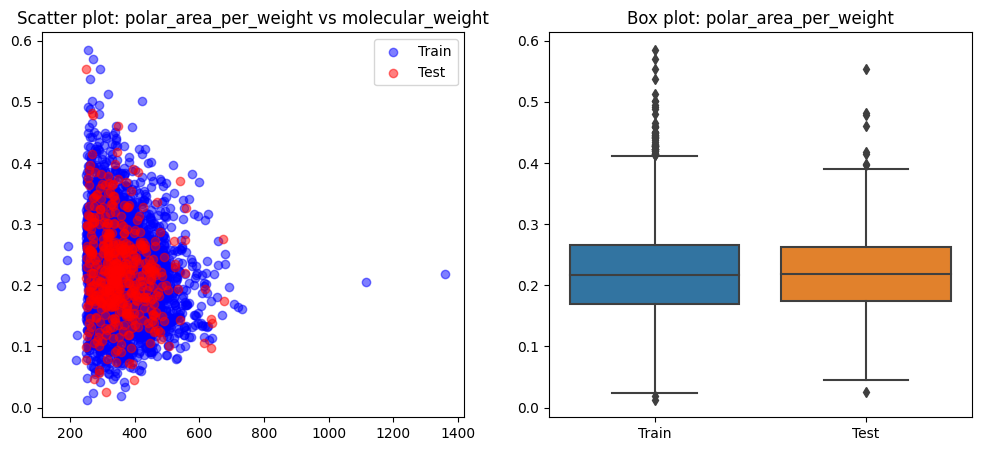

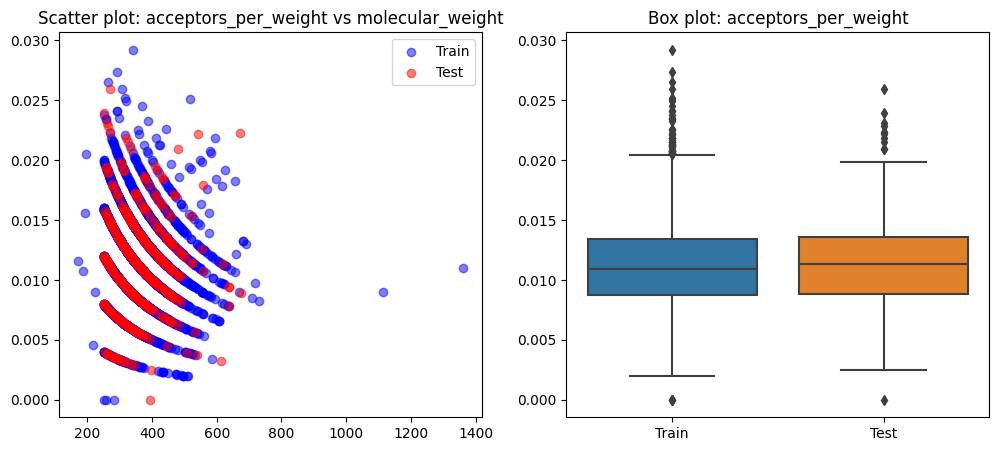

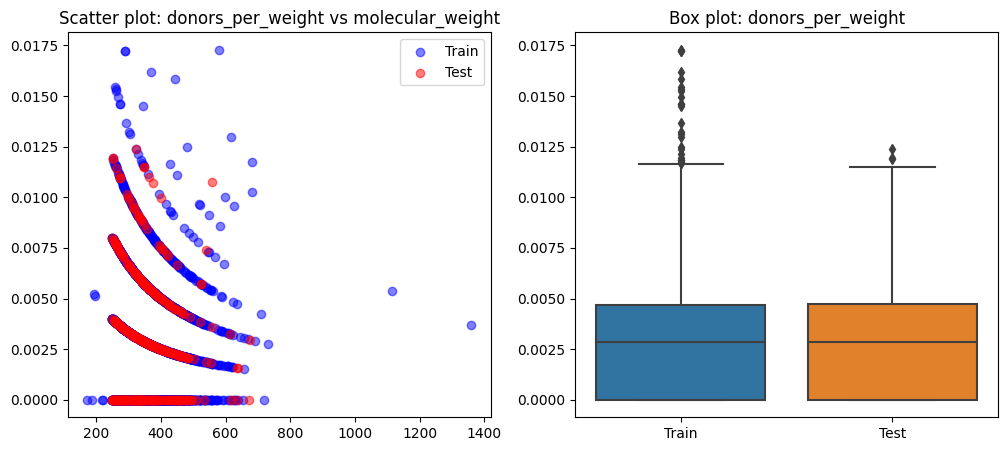

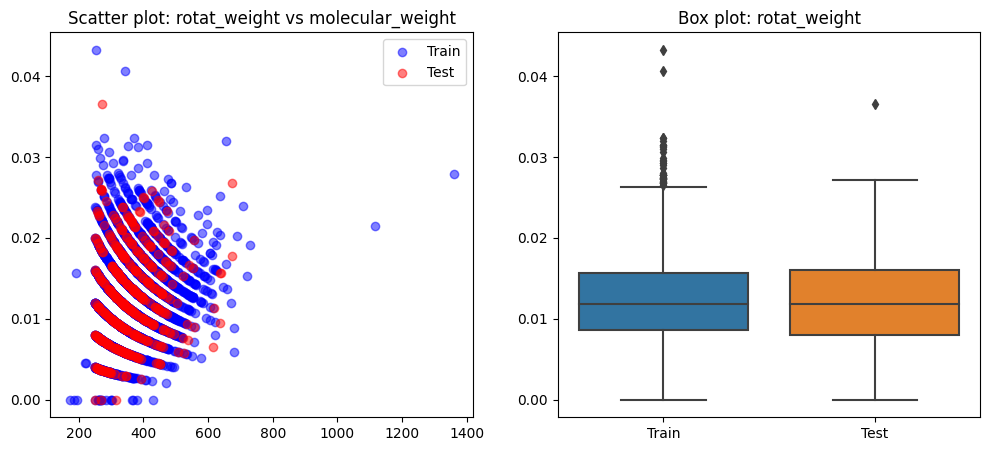

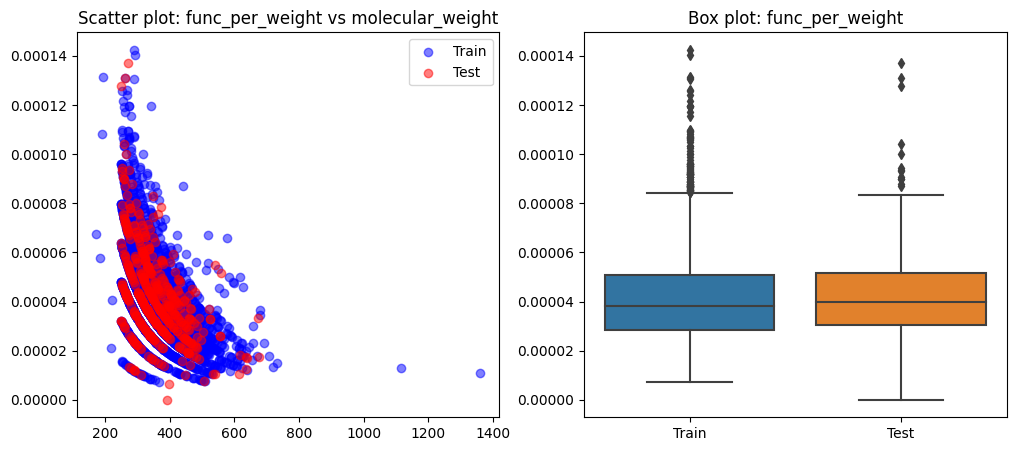

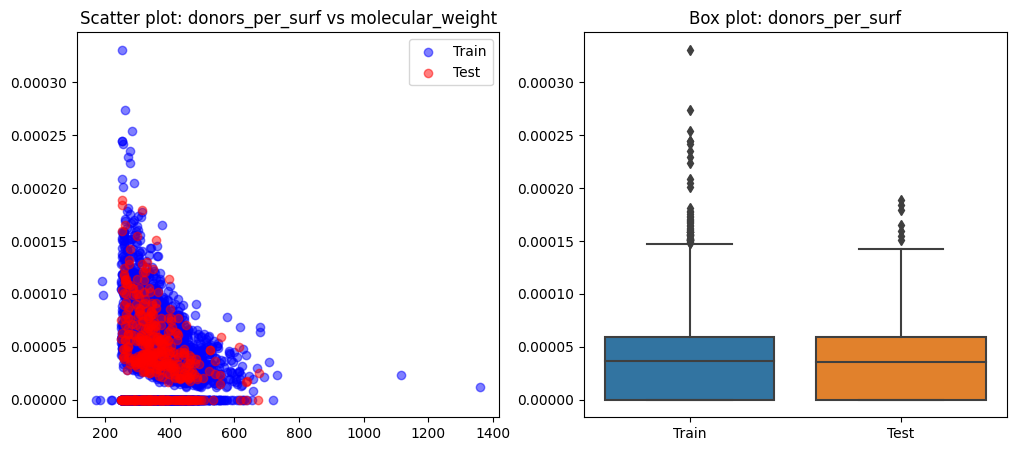

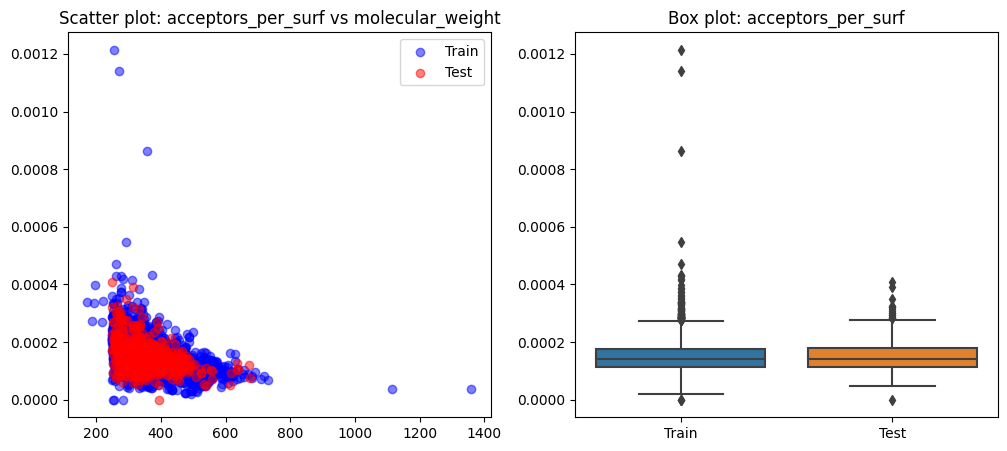

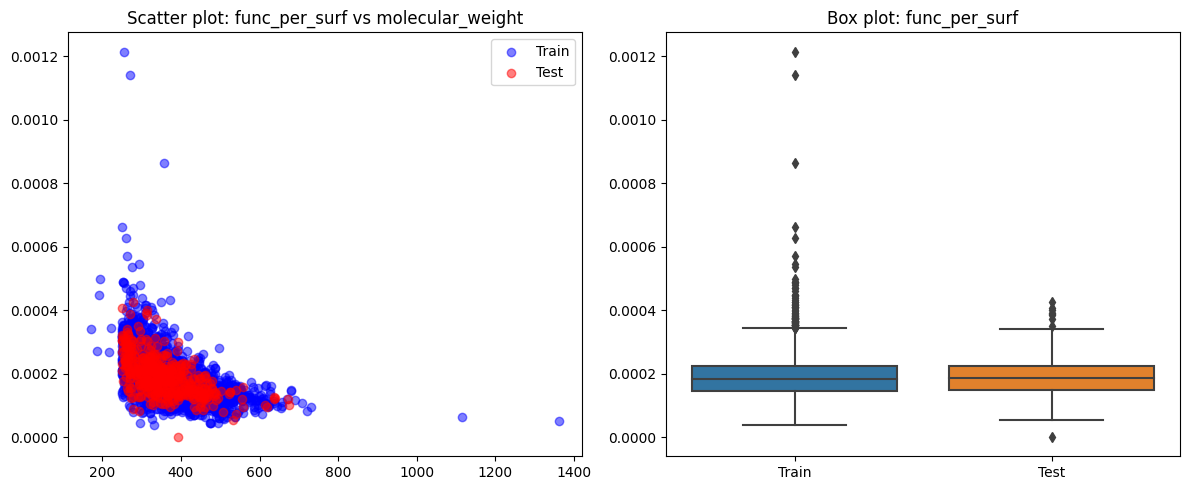

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_des=traincp.drop(["mlm","hlm"],axis=1,inplace=False)

numeric_cols = train_des.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 산점도 그리기 (이때 X축은 'molecular_weight' 피쳐이고, y축이 보려는 피쳐)
    axs[0].scatter(train['molecular_weight'], train_des[col], color='blue', label='Train', alpha=0.5)
    axs[0].scatter(test_eda['molecular_weight'], test_eda[col], color='red', label='Test', alpha=0.5)
    axs[0].set_title(f'Scatter plot: {col} vs molecular_weight')
    axs[0].legend()

    # 박스플롯 그리기 (보려는 피쳐값을 XY로 나눠 보기)
    combined_df = pd.DataFrame({ 'Train': train_des[col], 'Test': test_eda[col] })
    box_plot = sns.boxplot(data=combined_df, ax=axs[1])
    box_plot.set_title(f'Box plot: {col}')

plt.tight_layout()
plt.show()


## 왜도 첨도 확인

In [ ]:
from scipy.stats import skew, kurtosis

# 숫자형 열만 선택
numeric_cols_train = set(train.select_dtypes(include=[np.number]).columns)
numeric_cols_test = set(test.select_dtypes(include=[np.number]).columns)

# 두 데이터 프레임에서 공통된 열만 선택
common_cols = numeric_cols_train.intersection(numeric_cols_test)

for col in common_cols:
    print(f"Column: {col}")

    print("Train")
    # 왜도
    print(f"Skewness: {skew(train[col].dropna())}")  # 결측치 제거 후 계산
    # 첨도
    print(f"Kurtosis: {kurtosis(train[col].dropna(), fisher=True)}")  # 결측치 제거 후 계산



    print("Test")
    # 왜도
    print(f"Skewness: {skew(test[col].dropna())}")  # 결측치 제거 후 계산
    # 첨도
    print(f"Kurtosis: {kurtosis(test[col].dropna(), fisher=True)}")  # 결측치 제거 후 계산

    print("---"*20)


Column: logd
Train
Skewness: -0.16076964840442454
Kurtosis: 0.4068397147053333
Test
Skewness: 0.23508168979795732
Kurtosis: 0.6845990179259918
------------------------------------------------------------
Column: num_rotatablebonds
Train
Skewness: 1.7491023144010707
Kurtosis: 13.955511328723276
Test
Skewness: 0.9060444649705507
Kurtosis: 1.9639815765654225
------------------------------------------------------------
Column: num_h_donors
Train
Skewness: 1.3086213325367684
Kurtosis: 4.89503584745913
Test
Skewness: 0.9028265586353155
Kurtosis: 1.1119600741322353
------------------------------------------------------------
Column: molecular_weight
Train
Skewness: 1.5765825636939301
Kurtosis: 9.693800821026455
Test
Skewness: 1.1303255507312893
Kurtosis: 1.9424295299836922
------------------------------------------------------------
Column: molecular_polarsurfacearea
Train
Skewness: 0.7316909395606567
Kurtosis: 1.9194372279707475
Test
Skewness: 0.5957585682902687
Kurtosis: 1.1898095037351393


## 상관관계 확인
### 히트맵

<ipython-input-23-46e316da1d3c>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


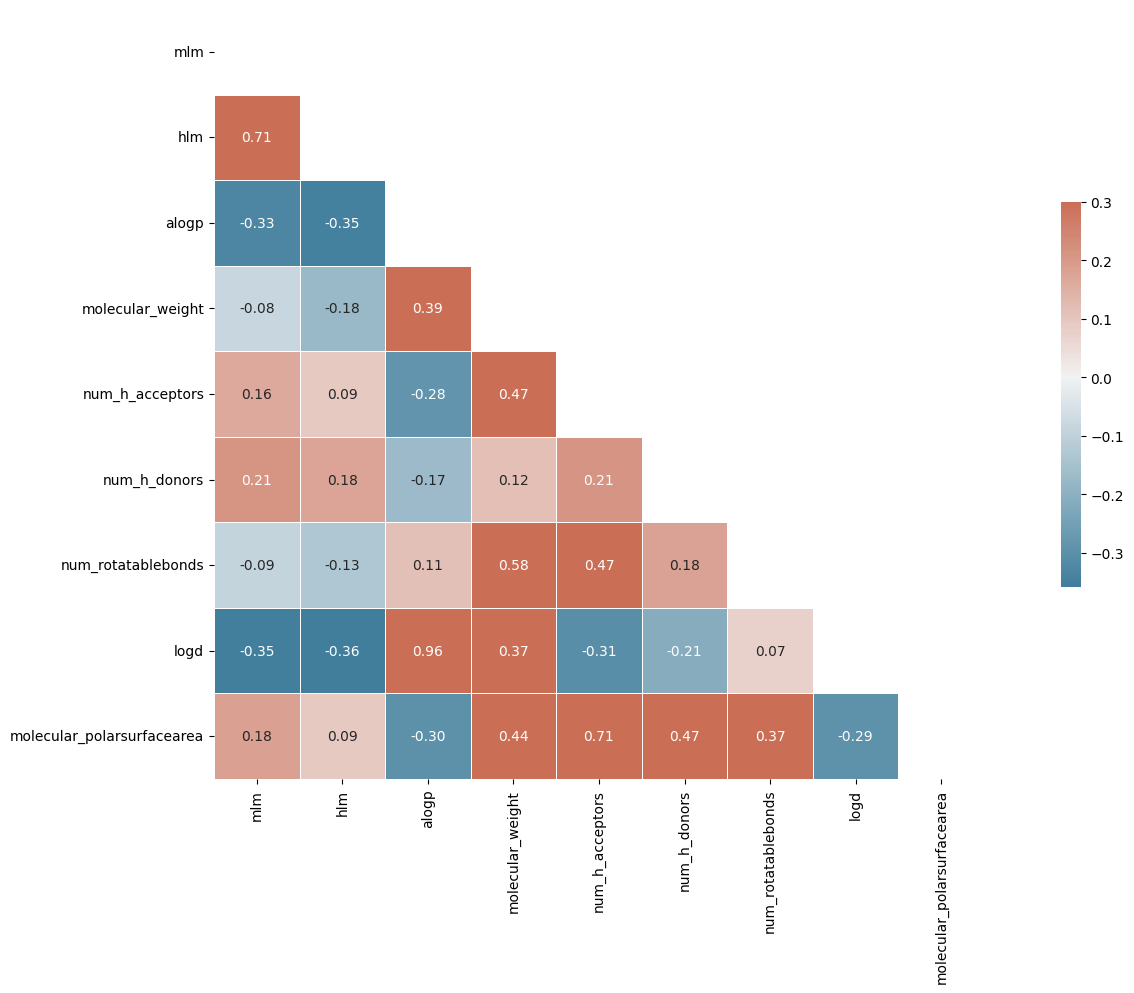

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
corr = train.corr()
# 마스크 설정 (상삼각행렬의 마스크를 만듭니다)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# 색상 맵 설정
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f", annot=True)
plt.show()


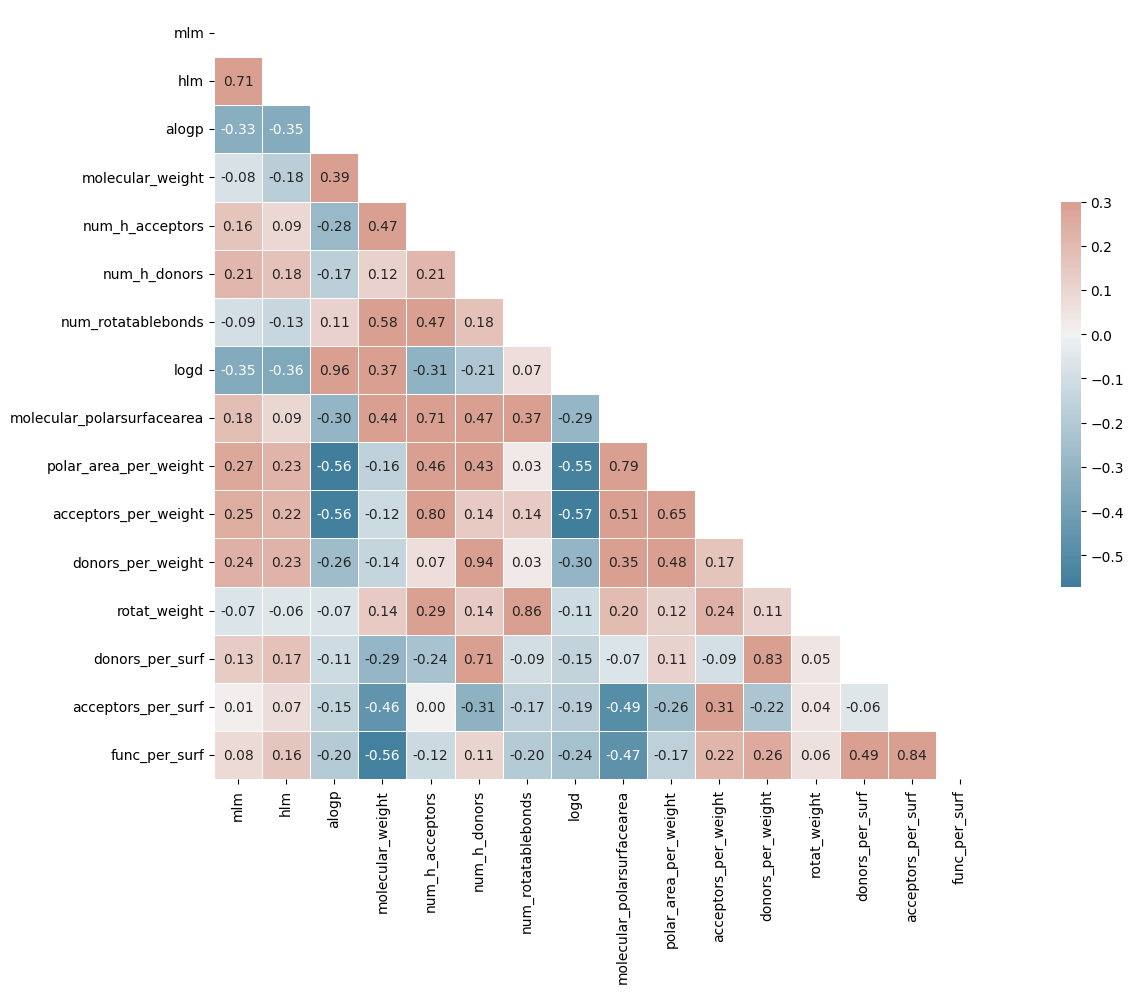

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
corr = traincp.corr()
# 마스크 설정 (상삼각행렬의 마스크를 만듭니다)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# 색상 맵 설정
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f", annot=True)
plt.show()


# RMSE 점수확인 함수 만들기
* train_test_split

In [ ]:
def my_score(train):
    rmse_list=[]
    y = train['hlm']
    X = train.drop(['hlm','mlm'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
    model= GradientBoostingRegressor(random_state=seed)
    model.fit(X_train, y_train)
    fold = KFold(n_splits=20, shuffle=True, random_state=seed)
    cv_mse = -1* cross_val_score(model, X_train, y_train, cv=fold, scoring="neg_mean_squared_error",n_jobs=-1)
    print(model.__class__.__name__)
    print(f"mse(cv):{cv_mse.mean():.4f}  rmse(cv):{np.sqrt(cv_mse.mean()):.4f}")
    rmse_list.append(np.sqrt(cv_mse.mean()))
    y = train['mlm']
    X = train.drop(['hlm','mlm'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
    model.fit(X_train, y_train)

    cv_mse = -1* cross_val_score(model, X_train, y_train, cv=fold, scoring="neg_mean_squared_error",n_jobs=-1)
    print(model.__class__.__name__)
    print(f"mse(cv):{cv_mse.mean():.4f}  rmse(cv):{np.sqrt(cv_mse.mean()):.4f}")
    rmse_list.append(np.sqrt(cv_mse.mean()))
    return np.mean(rmse_list)

In [ ]:
my_score(traincp) # 결측값이 있어 점수 내지 못함

ValueError: ignored

# 결측값 대치
* alogp 결측 2개를 회귀모형을 통해 결측처리함

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# alogp가 null이 아닌 행과 null인 행 분리
train_train = train[train['alogp'].notnull()]
train_test = train[train['alogp'].isnull()]

# 학습 데이터 설정 (alogp가 null이 아닌 데이터)
y_train_train = train_train['alogp']
X_train_train = train_train.drop(['alogp','smiles','id','hlm','mlm'], axis=1) #- id랑 smiles 컬럼 여기서 삭제

# 테스트 데이터 설정 (alogp가 null인 데이터)
X_test = train_test.drop(['alogp','smiles','id','hlm','mlm'], axis=1) #- id랑 smiles 컬럼 여기서 삭제
test_test = test.drop(['alogp','smiles','id'], axis=1) #- id랑 smiles 컬럼 여기서 삭제


In [ ]:
gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X_train_train,y_train_train)
pred_train = gbr.predict(X_test)
pred_test = gbr.predict(test_test)


In [ ]:
print("채우기 전:" , train[train['alogp'].isna()].shape )
idx_train = X_test.index.values
train.loc[idx_train, 'alogp'] = pred_train
print("0채우기 후:" , train[train['alogp'].isna()].shape )

print("채우기 전:" , test[test['alogp'].isna()].shape )
idx_test = test_test.index.values
test.loc[idx_test, 'alogp'] = pred_test
print("0채우기 후:" , test[test['alogp'].isna()].shape )

채우기 전: (2, 11)
0채우기 후: (0, 11)
채우기 전: (1, 9)
0채우기 후: (0, 9)


In [ ]:
train_cp=train.copy()
test_cp=test.copy()

In [ ]:
train_cp.drop(['smiles',"id"],axis=1,inplace=True)
test_cp.drop(['smiles',"id"],axis=1,inplace=True)

In [ ]:
my_score(train_cp)

GradientBoostingRegressor
mse(cv):1076.6590  rmse(cv):32.8125
GradientBoostingRegressor
mse(cv):1043.5018  rmse(cv):32.3033


32.55788038348215

## 아웃라이어 제거

In [ ]:
# 분자량 아웃라이어 제거
train = train.drop(train[train['molecular_weight']>1000].index)
# alogp,logd 아웃라이어 제거
train = train.drop(train[train['alogp']<-2.5].index) #이거 열면 0.324
train = train.drop(train[train['logd']<-2.5].index)
# 파생피쳐(임시) 아웃라이어 제거
train = train.drop(train[((train['num_h_acceptors']+train['num_h_donors'])/train['molecular_polarsurfacearea']<0.021) | ((train['num_h_acceptors']+train['num_h_donors'])/train['molecular_polarsurfacearea']>0.15)].index)
train = train.drop(train[((train['num_h_acceptors']+train['num_h_donors'])/train['molecular_weight']>0.0371)].index)
# 타겟피쳐 아웃라이어(이론적으로 불가능한 결과) 제거
del_idx_list = []
del_idx_list.extend(train[train['mlm'] > 100 ].index)
del_idx_list.extend(train[train['hlm'] > 100 ].index)
len(del_idx_list)
train = train.drop(index=del_idx_list)


In [ ]:
my_score(train_cp)

GradientBoostingRegressor
mse(cv):1049.4437  rmse(cv):32.3951
GradientBoostingRegressor
mse(cv):1007.2519  rmse(cv):31.7372


32.06617559030735

# 중복 데이터 처리
* 아래 3가지 옵션 중 예측값으로 대체를 선택
  * 중복데이터 제거,
  * 모델 예측값으로 대체 ,
  * 예측값과 가장 가까운 실제데이터로반영


In [ ]:
duplicates = train[train.duplicated(subset='smiles', keep=False)]
sorted_duplicates = duplicates.sort_values('smiles')
sorted_duplicates.head(4)

,id,smiles,mlm,hlm,alogp,molecular_weight,num_h_acceptors,num_h_donors,num_rotatablebonds,logd,molecular_polarsurfacearea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.6
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.6
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.0
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.0


In [ ]:
# mlm
# 중복 값이 있는 열 찾기 - first
dup_idx = train[train.duplicated(subset='smiles', keep=False)].index
dup_idx_1 = train[train.duplicated(subset='smiles', keep='first')].index
print(len(dup_idx),len(dup_idx_1))

# 중복 값을 가진 행을 제외한 나머지 데이터로 회귀 모델을 학습
# 중복행과 아닌 행 분리
train_dup = train.loc[dup_idx_1,:]
train_nodup = train.loc[~train.index.isin(dup_idx)]

# 학습 데이터 설정 (중복이 아닌 행)
X_train = train_nodup.drop(['smiles','id','mlm'], axis=1)
y_train = train_nodup['mlm']

# 테스트 데이터 설정(중복행)
X_test = train_dup.drop(['smiles','id','mlm'], axis=1)

52 26


In [ ]:
gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X_train,y_train)
pred = gbr.predict(X_test)

In [ ]:
#예측값으로 대체
for idx in dup_idx_1:
    # 현재 인덱스에 해당하는 예측값을 가져옴
    current_pred = pred[np.where(dup_idx_1 == idx)[0][0]]
    # 현재 인덱스와 같은 'smiles' 값을 가지는 모든 행(dup_idx)을 찾음.
    train.loc[idx, 'mlm']=current_pred

In [ ]:
# hlm
# 중복 값이 있는 열 찾기 - first
dup_idx = train[train.duplicated(subset='smiles', keep=False)].index
dup_idx_1 = train[train.duplicated(subset='smiles', keep='first')].index

# 중복 값을 가진 행을 제외한 나머지 데이터로 회귀 모델을 학습
# 중복행과 아닌 행 분리
train_dup = train.loc[dup_idx_1,:]
train_nodup = train.loc[~train.index.isin(dup_idx)]

# 학습 데이터 설정 (중복이 아닌 행)
X_train = train_nodup.drop(['smiles','id','hlm'], axis=1)
y_train = train_nodup['hlm']

# 테스트 데이터 설정(중복행)
X_test = train_dup.drop(['smiles','id','hlm'], axis=1)


In [ ]:
gbr = GradientBoostingRegressor(random_state=11)
gbr.fit(X_train,y_train)
pred = gbr.predict(X_test)

In [ ]:
#예측값으로 대체
for idx in dup_idx_1:
    # 현재 인덱스에 해당하는 예측값을 가져옵니다.
    current_pred = pred[np.where(dup_idx_1 == idx)[0][0]]
    # 현재 인덱스와 같은 'smiles' 값을 가지는 모든 행(dup_idx)을 찾습니다.
    train.loc[idx, 'hlm']=current_pred

In [ ]:
train_ml=train.copy()
train_ml.drop(['smiles',"id"],axis=1,inplace=True)
my_score(train_ml)

GradientBoostingRegressor
mse(cv):1046.1311  rmse(cv):32.3440
GradientBoostingRegressor
mse(cv):1003.8383  rmse(cv):31.6834


32.013679126238884

In [ ]:
train.drop(['smiles',"id"],axis=1,inplace=True)
test.drop(['smiles',"id"],axis=1,inplace=True)

y = train['mlm']
X = train.drop(['hlm','mlm'], axis=1)

gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X,y)
ML_pred_mlm = gbr.predict(test)

In [ ]:
y = train['hlm']
X = train.drop(['hlm','mlm'], axis=1)

gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X,y)
ML_pred_hlm = gbr.predict(test)

In [ ]:
sub_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/medicine/sample_submission.csv")
print(sub_df.shape)
sub_df.head()

(483, 3)


,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0
3,TEST_003,0,0
4,TEST_004,0,0


In [ ]:
sub_df['MLM'] = ML_pred_mlm
sub_df['HLM'] = ML_pred_hlm

* public score(rmse) :  30.04 (281위)  

# 대회 주최측 제공 딥러닝  Base line  코드
* public score(rmse) :  33.686

## Pre-Processing

In [ ]:
PandasTools.AddMoleculeColumnToFrame(train,'smiles','Molecule') # 기존의 'SMILES' 열에서 SMILES 문자열을 읽어들여, 그것을 분자 객체(molecular object)로 변환하고, 그 결과를 새로운 'Molecule' 열에 저장
PandasTools.AddMoleculeColumnToFrame(test,'smiles','Molecule')

In [ ]:
def mol2fp(mol):    #분자 객체를 입력받아 해당 분자의 지문(fingerprint)을 계산하고, 그 결과를 numpy 배열로 반환
    fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8) #결과를 저장할 numpy 배열(ar)을 초기화
    DataStructs.ConvertToNumpyArray(fp, ar) #계산된 지문(fp)를 numpy 배열(ar)로 변환
    return ar

In [ ]:
# FPs column 추가
train["FPs"] = train.Molecule.apply(mol2fp) # 'Molecule' 열의 모든 행에 mol2fp 함수를 적용->계산된지문이 fps열로 들어온다
test["FPs"] = test.Molecule.apply(mol2fp)

In [ ]:
train['FPs']

0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
3493    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3494    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3495    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3496    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
3497    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: FPs, Length: 3498, dtype: object

In [ ]:
len(train['FPs'][2324])

4096

,id,smiles,mlm,hlm,alogp,molecular_weight,num_h_acceptors,num_h_donors,num_rotatablebonds,logd,molecular_polarsurfacearea,Molecule,FPs
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."

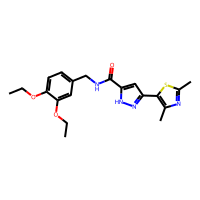
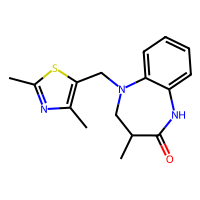
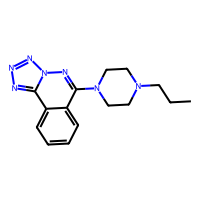
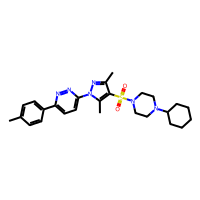
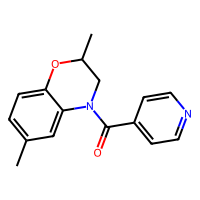
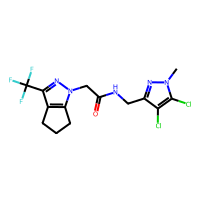
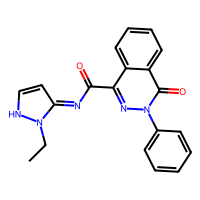
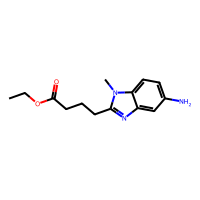
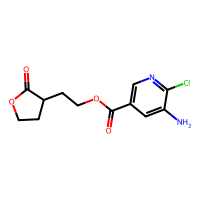
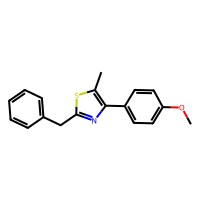

In [ ]:
train

In [ ]:
# 사용할 column만 추출
train_dl = train[['FPs','mlm', 'hlm']]
test_dl = test[['FPs']]

## Custom Dataset

In [ ]:

class CustomDataset(Dataset): # PyTorch의 Dataset 클래스를 상속받아 사용자 정의 데이터셋 클래스를 만듦 . 이 클래스는 학습, 검증, 테스트 데이터셋을 처리하는데 사용
#PyTorch는 딥러닝 연구와 개발에 널리 사용되는 오픈소스 라이브러리. PyTorch는 텐서 연산, 자동 미분 기능, GPU 가속 등을 제공하며, 이를 활용해 다양한 딥러닝 모델을 구현하고 학습할 수 있음
    def __init__(self, df, target, transform, is_test=False):   #초기화 메소드,이 메소드가 호출되면 객체가 생성됨, 4개의 매개변수를 받음
        # 입력으로 받은 매개변수들을 객체의 속성으로 저장
        self.df = df
        self.target = target # HLM or MLM
        self.is_test = is_test # train,valid / test

#'FPs' 열에서 지문(fingerprint) 벡터를 가져와서 transform(전처리 단계)을 거친 후 해당 결과를 저장
        self.feature_select = transform # transform은 전처리 단계, 주어진 피처 선택 방법(예: PCA, SelectKBest 등)을 적용.
        if not self.is_test:
            self.fp = self.feature_select.fit_transform(np.stack(df['FPs']))

        else: # valid or test 테스트 데이터셋인 경우 fit 과정 없이 바로 transform만 수행
            self.fp = self.feature_select.transform(np.stack(df['FPs']))

    def __getitem__(self, index): # 인덱스를 입력받아 해당 인덱스의 샘플을 반환.
        fp = self.fp[index] #  저장된 지문(fingerprint) 벡터들(self.fp) 중에서 입력받은 인덱스에 해당하는 벡터를 선택
        if not self.is_test: # test가 아닌 경우(label;타겟값 존재)
            label = self.df[self.target][index] #데이터프레임(self.df)에서 타깃 컬럼(self.target)의 특정 인덱스(index)에 해당하는 값을 가져옴
            return torch.tensor(fp).float(), torch.tensor(label).float().unsqueeze(dim=-1) # feature, label,지문 벡터와 레이블을 PyTorch의 Tensor 형태로 변환한 후 반환

        else: # test인 경우
            return torch.tensor(fp).float() # feature

    def __len__(self): # 데이터셋의 총 샘플 수를 반환
        return len(self.df)

In [ ]:
# reset_index 호출
train_dl = train_dl.reset_index(drop=True)   #데이터프레임의 인덱스를 리셋, 기존인덱스 삭제

transform = VarianceThreshold(threshold=0.05) #분산이 특정 임곗값(여기서는 0.05) 이하인 피처들을 제거하는 전처리 객체를 생성

train_MLM = CustomDataset(df=train_dl, target='mlm', transform=transform, is_test=False) # 'mlm' 컬럼을 타겟으로 하여 CustomDataset 생성. 입력된 데이터프레임(train_dl)에 전처리 적용
train_HLM = CustomDataset(df=train_dl, target='hlm', transform=transform, is_test=False)

input_size = train_MLM.fp.shape[1] #  지문(fingerprint) 벡터의 차원 수(즉, 피처 수)를 가져와 저장
input_size

249

In [ ]:
# Hyperparameter
CFG = {'BATCH_SIZE': 256,   # 한 번에 처리할 데이터의 개수. 너무 크면 메모리 부족 문제가, 너무 작으면 학습 속도가 느려짐
       'EPOCHS': 1000, # 전체 데이터셋을 몇 번 반복해서 학습할지 결정
       'INPUT_SIZE': input_size, # 모델의 입력 차원 수, 지문 벡터의 차원 수와 동일
       'HIDDEN_SIZE': 1024, # 은닉층의 노드(유닛) 개수, 이 값이 클수록 모델 복잡도가 증가하며, 과대적합 위험
       'OUTPUT_SIZE': 1, # 출력 차원 수, 회귀 문제에서는 보통 1로 설정
       'DROPOUT_RATE': 0.8, # 드롭아웃 비율로, 과대적합 방지를 위해 일부 노드를 임의로 꺼버리는 비율
       'LEARNING_RATE': 0.001} # 경사 하강법에서 사용하는 학습률. 너무 크면 최적점을 찾지 못하고 진동, 너무 작으면 학습 속도가 느려짐

In [ ]:
# 이 코드는 전체 데이터를 학습과 검증 용도로 나누고, 그 다음 각각의 용도별로 배치 크기만큼씩 자동으로 묶어서 제공할 수 있는 준비를 하는 과정

# train,valid split
train_MLM_dataset, valid_MLM_dataset = train_test_split(train_MLM, test_size=0.2, random_state=506)
train_HLM_dataset, valid_HLM_dataset = train_test_split(train_HLM, test_size=0.2, random_state=506)

# DataLoader: PyTorch에서 제공하는 클래스로, 배치 사이즈만큼의 데이터를 자동으로 묶어주며 필요에 따라 섞어줌(shuffle=True).
#이렇게 만들어진 DataLoader 객체는 반복문에서 사용할 수 있음

train_MLM_loader = DataLoader(dataset=train_MLM_dataset,   #
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_MLM_loader = DataLoader(dataset=valid_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)


train_HLM_loader = DataLoader(dataset=train_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_HLM_loader = DataLoader(dataset=valid_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)

## Model
* PyTorch를 사용하여 신경망 모델을 정의

In [ ]:
class Net(nn.Module): #PyTorch의 기본 모듈인 nn.Module을 상속받습니다. 따라서 이 클래스는 신경망 모델을 나타냄
    def __init__(self, input_size, hidden_size, dropout_rate, out_size): # 초기화함수, 네트워크의 구조와 필요한 매개변수들을 정의
        super(Net, self).__init__()

        # fc 레이어 3개와 출력 레이어 , 선형 레이어(완전 연결 레이어)를 정의,각 레이어는 입력 크기와 출력 크기를 인자로 받음
        # 입력크기:모델이 한 번에 받아들일 수 있는 데이터의 차원을 의미, 여기선 input_size는 지문 벡터의 차원 수
        # 이미지를 처리하는 경우 입력 크기는 이미지의 너비, 높이, 채널 수로 결정

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        # 출력크기: 모델이 예측하려고 하는 값의 차원을 의미. 회귀 문제에서 출력 크기는 보통 1(하나의 연속적인 값을 예측). 분류 문제에서 출력 크기는 클래스의 개수

        # 정규화,각 샘플 내에서 피처들을 독립적으로 정규화하여 학습 속도를 개선하고 일반화 성능을 향상
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)

        # 활성화 함수
        self.activation = nn.LeakyReLU()

        # Dropout, 과대적합방지
        self.dropout = nn.Dropout(dropout_rate)


# forward 메소드에서 실제 데이터가 네트워크 통과할 때 어떻게 처리되는지 순서대로 작성됨
# 입력 데이터가 네트워크에 들어오면 세 개의 완전 연결 계층(각 계층 후에 LayerNorm과 활성화 함수, 드롭아웃 적용)을 거친 후
# 마지막 출력 계층으로 전달되고 그 결과가 반환되도록 설계된 심층 신경망
    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out

In [ ]:
model_MLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])
model_HLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])

In [ ]:
criterion = nn.MSELoss() # 손실 함수로 평균 제곱 오차(Mean Squared Error, MSE)를 사용
optimizer_MLM = torch.optim.Adam(model_MLM.parameters(), lr=CFG['LEARNING_RATE']) #파라미터를 최적화하기 위한 최적화 알고리즘으로 Adam 사용
optimizer_HLM = torch.optim.Adam(model_HLM.parameters(), lr=CFG['LEARNING_RATE'])

## Training

In [ ]:
def train(train_loader, valid_loader, model, criterion, optimizer, epochs):
    model.train()  #모델을 학습 모드로 설정,Dropout과 같은 일부 레이어에서 학습과 평가 시 동작이 다르기 때문에 필요

    for epoch in range(epochs):
        running_loss = 0
        for inputs, targets in train_loader: # train_loader로부터 배치 크기만큼의 입력 데이터와 타겟 값을 가져옴
            optimizer.zero_grad()  # 기울기를 0으로 초기화합니다. PyTorch는 기본적으로 기울기를 누적시키므로, 각 배치에서 새로운 경사 계산을 시작하기 전에 이전 경사를 지워줌

            output = model(inputs) # 현재 배치의 입력 데이터를 모델에 통과시켜 출력값(예측값)을 얻음
            loss = criterion(output, targets) #  예측값과 실제 타겟 값 사이의 손실값을 계산
            loss.backward()  # 역전파 알고리즘으로 손실 함수의 그래디언트를 계산하고,
            optimizer.step() # 이 그래디언트 정보를 사용하여 최적화 알고리즘이 가중치들을 업데이트

            running_loss += loss.item() # loss.item()은 현재 배치의 손실값이라는 Python 숫자를 반환

        if epoch % 100 == 0: # 100 에폭마다 검증 과정이 실행
            valid_loss = 0
            with torch.no_grad(): # 검증 과정에서는 가중치 업데이트 없이 모델의 성능만 확인하기 때문에, 그래디언트 계산이 필요하지 않음
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = criterion(output, targets)
                    valid_loss += loss.item()

            print(f'Epoch: {epoch}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss/len(valid_HLM_loader)}')

            model.train()

    return model

In [ ]:
print("Training Start: MLM")
model_MLM = train(train_MLM_loader, valid_MLM_loader, model_MLM, criterion, optimizer_MLM, epochs=CFG['EPOCHS'])

print("Training Start: HLM")
model_HLM = train(train_HLM_loader, valid_HLM_loader, model_HLM, criterion, optimizer_HLM, epochs=CFG['EPOCHS'])

Training Start: MLM
Epoch: 0/1000, Train Loss: 2075.8227982954545, Valid Loss: 1687.8943684895833
Epoch: 100/1000, Train Loss: 336.8472928133878, Valid Loss: 1328.4852701822917
Epoch: 200/1000, Train Loss: 191.50139409845525, Valid Loss: 1379.6526285807292
Epoch: 300/1000, Train Loss: 131.73827847567472, Valid Loss: 1241.5409749348958
Epoch: 400/1000, Train Loss: 107.3012924194336, Valid Loss: 1298.9868977864583
Epoch: 500/1000, Train Loss: 97.02413801713423, Valid Loss: 1285.5637613932292
Epoch: 600/1000, Train Loss: 91.08777340975675, Valid Loss: 1450.562255859375
Epoch: 700/1000, Train Loss: 80.67787829312411, Valid Loss: 1358.6142171223958
Epoch: 800/1000, Train Loss: 64.64786356145686, Valid Loss: 1409.5880126953125
Epoch: 900/1000, Train Loss: 62.00392844460227, Valid Loss: 1364.3339029947917
Training Start: HLM
Epoch: 0/1000, Train Loss: 3256.658136541193, Valid Loss: 2616.724609375
Epoch: 100/1000, Train Loss: 399.5210266113281, Valid Loss: 1401.3495279947917
Epoch: 200/1000, T

결과를 보면, 'Train Loss'는 에폭이 진행됨에 따라 지속적으로 감소하는 반면, 'Valid Loss'는 일정 수준에서 유지되거나 증가하는 경향을 보입니다. 이러한 현상은 과적합(overfitting)을 의미할 수 있습니다. 즉, 모델이 훈련 데이터에 너무 맞춰져서 새로운 데이터(여기서는 검증 데이터)에 대한 예측 성능이 떨어집니다.

모델 학습 시 과적합을 방지하고 일반화 성능을 개선하기 위해 여러 가지 방법들이 있습니다:

Early Stopping: 검증 손실이 더 이상 감소하지 않으면 학습을 조기 종료합니다.
Regularization: 가중치 크기를 제한하여 복잡성을 줄입니다(L1, L2 정규화 등).
Dropout: 학습 과정에서 신경망의 일부를 임의로 비활성화하여 복잡성을 줄입니다.
Data Augmentation: 원본 훈련 데이터를 약간 변형하여 새로운 학습 예제를 생성합니다.
위와 같은 방법들 중 하나 혹은 여러 가지를 사용해보면 모델의 과적합 문제를 완화하고 일반화 성능을 개선할 수 있습니다.

## Inference

In [ ]:
test_MLM = CustomDataset(df=test, target=None, transform=transform, is_test=True)
test_HLM = CustomDataset(df=test, target=None, transform=transform, is_test=True)

test_MLM_loader = DataLoader(dataset=test_MLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

test_HLM_loader = DataLoader(dataset=test_HLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

In [ ]:
def inference(test_loader, model):
    model.eval() #평가모드
    preds = []   # 예측값들을 저장할 빈 리스트를 초기화.


    with torch.no_grad():# 그래디언트 계산이 필요 없는 추론 단계에서 메모리 사용량을 줄이기 위해 그래디언트 계산을 비활성화
        for inputs in test_loader: #DataLoader 객체인 test_loader로부터 배치 크기만큼의 입력 데이터를 가져옴
            output = model(inputs)
            preds.extend(output.cpu().numpy().flatten().tolist()) # 출력 Tensor를 CPU 상의 NumPy 배열로 변환하고, 1차원으로 만든 후 Python 리스트로 바꾼 뒤 preds 리스트에 추가

    return preds

In [ ]:
baseline_predictions_MLM = inference(test_MLM_loader, model_MLM)
baseline_predictions_HLM = inference(test_HLM_loader, model_HLM)

* rmse :  33.686 (494위)  - >  전처리후 32.47(461위)

---



## Submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/medicine/sample_submission.csv')
submission

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0
3,TEST_003,0,0
4,TEST_004,0,0
...,...,...,...
478,TEST_478,0,0
479,TEST_479,0,0
480,TEST_480,0,0
481,TEST_481,0,0


In [ ]:
submission['MLM'] = (baseline_predictions_MLM + ML_pred_mlm)/2
submission['HLM'] = (baseline_predictions_HLM + ML_pred_hlm)/2
submission

,id,MLM,HLM
0,TEST_000,6.479746,17.931421
1,TEST_001,77.196548,85.224731
2,TEST_002,23.857519,59.615292
3,TEST_003,31.280436,72.798729
4,TEST_004,6.618256,87.582733
...,...,...,...
478,TEST_478,64.483360,37.669559
479,TEST_479,69.938271,93.475052
480,TEST_480,42.280838,50.363522
481,TEST_481,31.441042,63.653656


In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/medicine/result/baseline_submission_andmine.csv', index=False)

 * public score(rmse) : 첫 제출 32.47  (461위, 31.8%)  - >  최종 29.00 (164위, 11.5%)

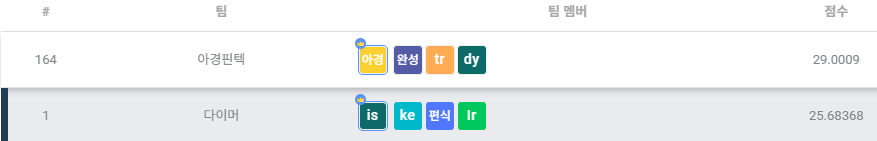